# Installing Packages

In [1]:
!pip install dataframe-image
!pip install pandas==1.5.3


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 42.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.5/398.5 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 55.7 MB/s eta 0:00:0000:010:01
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 2023.621.222118 requires jupyter-server~=1.16, but you have jupyter-server 2.6.0 which is incompatible.
fitter 1.6.0 requires pandas<3.0.0,>=2.0.3, but you have pandas 1.5.3 which is incompatible.
momepy 0.6.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.23.5 which is incompatible.
pymc3 3.11.5 

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/criminal-psychological-data/Criminal Psychological Dataset CSV.csv


# Importing Libraries

In [3]:
from sklearn.model_selection import LeaveOneOut

from sklearn.tree import DecisionTreeClassifier, export_graphviz # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score, cross_val_predict

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
from matplotlib import interactive
import matplotlib.image as mpimg
from matplotlib.pyplot import figure

# For plotting the classification results
from mlxtend.plotting import plot_decision_regions
import xgboost as xgb
from IPython.display import Image  
from six import StringIO

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import seaborn as sns
%matplotlib inline
from sklearn.metrics import make_scorer, f1_score, accuracy_score, confusion_matrix

# Dataset Processing

In [4]:
#reading and preparing datasets
org_ds = pd.read_csv('/kaggle/input/criminal-psychological-data/Criminal Psychological Dataset CSV.csv')

#converting all columns to lowercase to standardize uss
org_ds.columns = org_ds.columns.str.lower()

#dataset without non-numeric unwanted fields like date, time, patient number, zero change values
numeric_ds = org_ds.drop(['cid','cjdid','staffid','idate','intstrt','instrta','suindt','stjail','pre30jl','pre180jl','cdob',
                          'chethn1','crace1','c23cmin','c23cmdt','ag1sdin','sdinj30','intend','intenda','editdate','d2bi2pma',
                          'd2bi2pmb','d2bi2pmc','c18pdmcl','c18pdmcp','c18pdmca','c18spgmc','anytxpm','datadmit','entpro',
                          'compl','onset1','neworrec','environ','course','worst','worst2','txhispsy','txdralc','hospspec',
                          'hospmed','othprob3','whowith','currdx','lifedes1','lifedes2','lifedes3','lifetx3','lifedes4',
                          'lifetx4','lifedes5','lifetx8','screen6a','s61b','s61bs','c17cmdt'] , axis = 1)

print("After removing unimportant fields " , len(numeric_ds.columns))

#converting categorical values to integer by One Hot Encoding
numeric_ds = pd.get_dummies(numeric_ds, columns = ['clive1','job1','majsup1','othoff','othdrug','qtother1',
                                                             'othtx1','resptx1','a38spgmc','a40spsu','c20spsu','f29spsu',
                                                             'diff1','diff2','diff3','onset2','new2','othprob1','othprob2',
                                                             'medvit','alcdrug','freetime','ruleout','lifetx1','lifeage2',
                                                             'lifetx2','lifetx5','lifedes6','lifetx6','lifedes7','lifetx7','lifedes8'])

print("After converting categorical fields " , len(numeric_ds.columns))

# replace field that's entirely space (or empty) with NaN
numeric_ds = numeric_ds.replace(r'^\s*$', np.nan, regex=True)
    
for (columnName, columnData) in numeric_ds.iteritems():
    numeric_ds[columnName] = pd.to_numeric(numeric_ds[columnName])
    numeric_ds[columnName].fillna(numeric_ds[columnName].mean())
    numeric_ds[columnName] = numeric_ds[columnName].replace(np.nan, numeric_ds[columnName].mean())
    numeric_ds[columnName].astype(str).astype(float)
    
#removing special characters from feature names added by One Hot Encoding
import re
# Change columns names ([LightGBM] Do not support special JSON characters in feature name. We were using LightGBM initially instead of CatBoost)
new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in numeric_ds.columns}
new_n_list = list(new_names.values())
# [LightGBM] Feature appears more than one time.
new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
numeric_ds = numeric_ds.rename(columns=new_names)

#ds_woSuicide is processed dataset without features of suicide ideation
ds_woSuicide = numeric_ds.drop(['othoff_SUICIDEATTEMPTS','sidelf','mini4','mini4a','mhsf28a','mhsf29a','gain43',
                                'gain43a','gain44','gain44a','cursuic1','cursuic2','cursuic3','cursuic4','passuic1',
                                'passuic2','passuic3','passuic4','currsuic','pastsuic','sciddia1','sciddi1a','scidsev2'], axis = 1)

#ds_wSuicide is processed dataset with features of suicide ideation
ds_wSuicide = numeric_ds



#############Shap 27 features
#shap_woSuicide is dataset containing only top 27 features of SHAP from above processed datasets. Without suicide ideation features
shap_woSuicide = ds_woSuicide[['phosplf','scrns3b3','pdborder','mhsftot','scrn3md','suprob2','s65cs','alctype','age1coc',
                              'age1alc','new2_','age1tob','drgprb3','mhsf35a','hosptime','anxlf','mhsf28','s65a','d6mddlta',
                              'majsup','arstdrg','depend','drgprb2','scrns3b2','age','tcuds','c1cm30','sattlf']]

#shap_wSuicide is dataset containing only top 27 features of SHAP from above processed datasets. With suicide ideation features
shap_wSuicide = ds_wSuicide[['mhsf28a','sidelf','gain44','phosplf','age1jl','job','age1coc','drvlic','gain44a','coc6m','aspdtot',
                            'alctype','age1tob','c7cm6m','mshf10cs','clive','gain53a','suprob2','pdborder','age1mj','drgprb6',
                            'scrns3c3','arstdrg','allmon','hosptime','gs5a','depend','sattlf']]

##########Anchor 19 Features
#anchor_woSuicide is dataset containing only top 19 features of anchor from anchor explanatory rules from shap_woSuicide
anchor_woSuicide = ds_woSuicide[['phosplf','scrns3b3','scrn3md','pdborder','mhsftot','age','age1coc','hosptime','scrns3b2',
                              'mhsf28','mhsf35a','depend','arstdrg','alctype','d6mddlta','age1tob','c1cm30','tcuds',
                              'drgprb3','sattlf']]

#######Anchor 12 Features
#anchor_wSuicide is dataset containing only top 12 features of anchor from anchor explanatory rules from shap_wSuicide
anchor_wSuicide = ds_wSuicide[['mhsf28a','sidelf','gain44','pdborder','phosplf','depend','age1tob','arstdrg',
                            'gs5a','coc6m','age1mj','age1jl','sattlf']]

print("Columns in original dataset without suicide ideation" , len(ds_woSuicide.columns))
print("Columns in original dataset with suicide ideation" , len(ds_wSuicide.columns))
print("Columns in reduced dataset SHAP without suicide ideation" , len(shap_woSuicide.columns))
print("Columns in reduced dataset SHAP with suicide ideation" , len(shap_wSuicide.columns))
print("Columns in reduced dataset Anchor without suicide ideation" , len(anchor_woSuicide.columns))
print("Columns in reduced dataset Anchor with suicide ideation" , len(anchor_wSuicide.columns))

After removing unimportant fields  860
After converting categorical fields  2337


/tmp/ipykernel_32/2759040184.py:29: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (columnName, columnData) in numeric_ds.iteritems():


Columns in original dataset without suicide ideation 2314
Columns in original dataset with suicide ideation 2337
Columns in reduced dataset SHAP without suicide ideation 28
Columns in reduced dataset SHAP with suicide ideation 28
Columns in reduced dataset Anchor without suicide ideation 20
Columns in reduced dataset Anchor with suicide ideation 13


In [5]:
#PROCESSED DATASET WITHOUT SUICIDE IDEATION
X = ds_woSuicide.drop(['sattlf'], axis=1) #X training features
y = ds_woSuicide.sattlf #y output features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3) # 80% training and 20% test
#PROCESSED DATASET WITH SUICIDE IDEATION
X_s = ds_wSuicide.drop(['sattlf'], axis=1) #X training features
y_s = ds_wSuicide.sattlf #y output features
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, y_s, test_size=0.2, random_state=3) # 80% training and 20% test


#SHAP REDUCED DATASET WITHOUT SUICIDE IDEATION
X_r = shap_woSuicide.drop(['sattlf'], axis=1) #X training features
y_r = shap_woSuicide.sattlf #y output features
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_r, y_r, test_size=0.2, random_state=3) # 80% training and 20% test
#SHAP REDUCED DATASET WITH SUICIDE IDEATION
X_rs = shap_wSuicide.drop(['sattlf'], axis=1) #X training features
y_rs = shap_wSuicide.sattlf #y output features
X_train_rs, X_test_rs, y_train_rs, y_test_rs = train_test_split(X_rs, y_rs, test_size=0.2, random_state=3) # 80% training and 20% test


#ANCHOR REDUCED DATASET WITHOUT SUICIDE IDEATION
X_Ar = anchor_woSuicide.drop(['sattlf'], axis=1) #X training features
y_Ar = anchor_woSuicide.sattlf #y output features
X_train_Ar, X_test_Ar, y_train_Ar, y_test_Ar = train_test_split(X_Ar, y_Ar, test_size=0.2, random_state=3) # 80% training and 20% test
#ANCHOR REDUCED DATASET WITH SUICIDE IDEATION
X_Ars = anchor_wSuicide.drop(['sattlf'], axis=1) #X training features
y_Ars = anchor_wSuicide.sattlf #y output features
X_train_Ars, X_test_Ars, y_train_Ars, y_test_Ars = train_test_split(X_Ars, y_Ars, test_size=0.2, random_state=3) # 80% training and 20% test

# Functions & Methods

In [6]:
#Creating Dataframe table for displaying of performance metrics for ensemble models
#required for table image creation
metrics_name = ["Accuracy(%):", "F1-Score:", "Precision:", "Sensitivity:",
               "AUC:","PPV:", "Logloss:" , "True +:", "True -:",
               "False +:", "False -:"]
metrics_val = [0,1,2,3,4,5,6,7,8,9,10]

table_df = pd.DataFrame()
table_df["Metrics"] = metrics_name

def gen_performance_metrics(classifier , YT , YP):
    TN, FP, FN, TP = confusion_matrix(YT, YP).ravel()
    metrics_val[0] = round(accuracy_score(YT, YP)*100,2)
    metrics_val[1] = round(f1_score(YT, YP, average='macro'),3)
    metrics_val[2] = round(precision_score(YT, YP, average='micro'),3)
    metrics_val[3] = round(recall_score(YT, YP, average='binary'),3)
    metrics_val[4] = round(metrics.roc_auc_score(YT, YP),3)
    metrics_val[5] = round(TP/(TP+FP),3)
    metrics_val[6] = round(log_loss(YT, YP, eps=1e-5, normalize=True, sample_weight=None, labels=None),3)
    metrics_val[7] = TP
    metrics_val[8] = TN
    metrics_val[9] = FP
    metrics_val[10] = FN
    table_df[classifier] = metrics_val

# Ensemble Method

In [7]:
#ensemble techniques for classifiers
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score

useCV = False #for executing 10 fold cross validation
useLOO = False #for executing Leave One Out

def EnsembleClass(xTrain, xTest, yTrain, yTest, x, y):
    # Create classifer objects for XGBoost and Random Forest models
    xgbModel = xgb.XGBClassifier(objective="binary:logistic", learning_rate=0.3, 
                               booster='gbtree', max_depth=5, n_estimators=100, enable_categorical=False)
    randomForestModel = RandomForestClassifier(n_estimators=500)

    #Voting ensemble classifier of XGboost and Random Forest 
    class_model = VotingClassifier(
        estimators=[('xgb', xgbModel),('ranFor',randomForestModel)], voting='hard')

    # training all the model on the train dataset
    class_model.fit(xTrain, yTrain)
    # predicting the output on the test dataset
    y_pred = class_model.predict(xTest)
    
    if (useCV == True):
        ############# Cross validation
        scoring = {
            'f1': make_scorer(f1_score),
            'accuracy': make_scorer(accuracy_score),
        }
        # Calculate F1 score and accuracy using cross-validation
        f1_scores = cross_val_score(class_model, xTrain, yTrain, cv=10, scoring=scoring['f1'])
        accuracies = cross_val_score(class_model, xTrain, yTrain, cv=10, scoring=scoring['accuracy'])


        print("F1-Scores:", np.mean(f1_scores))
        print("Accuracies:", np.mean(accuracies))
        print()
        print()
        ###############
    if (useLOO == True):
        ############# Leave One Out Cross validation
        # Create a LeaveOneOut cross-validator
        loo = LeaveOneOut()

        # Create a list to store the cross-validation scores
        scores = []
        f1_scores = []
        count = 0
        # Iterate over the cross-validation splits
        for train_index, test_index in loo.split(x):
            print(count)
            count = count + 1
            # Train the model on the training set
            class_model.fit(x.iloc[train_index], y.iloc[train_index])

            # Make predictions on the test set
            y_pred = class_model.predict(x.iloc[test_index])

            # Calculate the accuracy score
            accuracy = np.mean(y_pred == y.iloc[test_index])

            # Append the accuracy score to the scores list
            scores.append(accuracy)

            # Calculate the F1-score
            f1 = f1_score(y.iloc[test_index], y_pred, zero_division = 0)
            f1_scores.append(f1)

        # Calculate the average cross-validation score
        mean_score = np.mean(scores)
        mean_f1 = np.mean(f1_scores)

        print("Average LOO cross-validation Accuracy:", mean_score)
        print("Average LOO cross-validation F1 Score:", mean_f1)
        ###############
             
    return y_pred

# Ensemble Execution

In [8]:
#running ensemble methods for classifiers

#Ensemble on Processed Datasets
y_pred_ens = EnsembleClass(X_train, X_test, y_train, y_test, X, y) #original dataset without suicide ideation
print()
y_pred_ens_s = EnsembleClass(X_train_s, X_test_s, y_train_s, y_test_s, X_s, y_s) #original with suicide ideation
print()

#Ensemble on SHAP Feature Datasets
y_pred_ens_r = EnsembleClass(X_train_r, X_test_r, y_train_r, y_test_r, X_r, y_r) #SHAP reduced dataset without suicide ideation
print()
y_pred_ens_rs = EnsembleClass(X_train_rs, X_test_rs, y_train_rs, y_test_rs, X_rs, y_rs) #SHAP reduced with suicide ideation
print()

#Ensemble on Anchor Feature Datasets
y_pred_ens_Ar = EnsembleClass(X_train_Ar, X_test_Ar, y_train_Ar, y_test_Ar, X_Ar, y_Ar) #Anchor reduced dataset without suicide ideation
print()
y_pred_ens_Ars = EnsembleClass(X_train_Ars, X_test_Ars, y_train_Ars, y_test_Ars, X_Ars, y_Ars) #Anchor reduced with suicide ideation
print()

         Metrics     ENS   ENS_s  ENS_Shap  ENS_Shap_s  ENS_Anchor  \
0   Accuracy(%):  91.550  97.180    92.960      98.590      92.960   
1      F1-Score:   0.727   0.930     0.814       0.967       0.833   
2     Precision:   0.915   0.972     0.930       0.986       0.930   
3   Sensitivity:   0.333   0.778     0.556       0.889       0.667   
4           AUC:   0.667   0.889     0.770       0.944       0.817   
5           PPV:   1.000   1.000     0.833       1.000       0.750   
6       Logloss:   0.973   0.324     0.811       0.162       0.811   
7        True +:   3.000   7.000     5.000       8.000       6.000   
8        True -:  62.000  62.000    61.000      62.000      60.000   
9       False +:   0.000   0.000     1.000       0.000       2.000   
10      False -:   6.000   2.000     4.000       1.000       3.000   

    ENS_Anchor_s  
0         98.590  
1          0.967  
2          0.986  
3          0.889  
4          0.944  
5          1.000  
6          0.162  
7      

<Figure size 640x480 with 0 Axes>

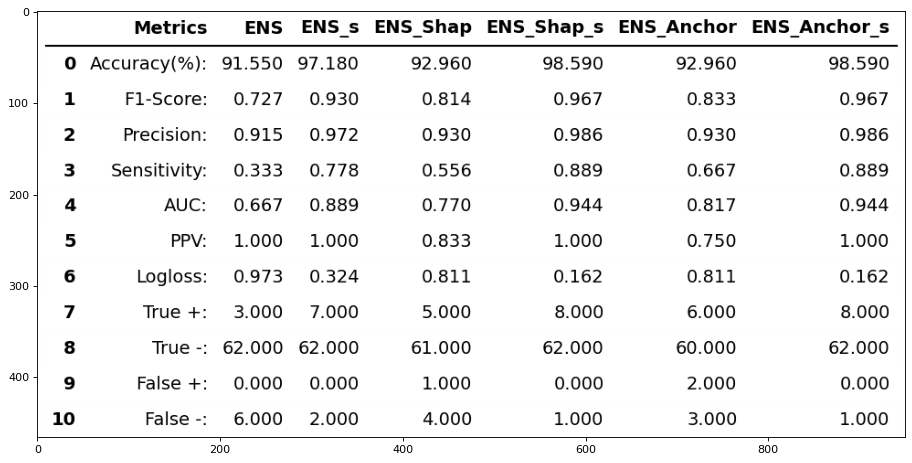

In [10]:
#Table visualization for ensemble model results
gen_performance_metrics("ENS" , y_test, y_pred_ens)
gen_performance_metrics("ENS_s" , y_test_s, y_pred_ens_s)
gen_performance_metrics("ENS_Shap" , y_test_r , y_pred_ens_r)
gen_performance_metrics("ENS_Shap_s" , y_test_rs , y_pred_ens_rs)
gen_performance_metrics("ENS_Anchor" , y_test_Ar , y_pred_ens_Ar)
gen_performance_metrics("ENS_Anchor_s" , y_test_Ars , y_pred_ens_Ars)

print(table_df)
plt.figure(3)
#plt.rcParams["figure.figsize"] = (20,20)
figure(figsize=(14, 12), dpi=80)

fileName = "Ensemble Table.png"

import dataframe_image as dfi
dfi.export(
    table_df,
    fileName,
    table_conversion="matplotlib"
)

img = mpimg.imread("/kaggle/working/" + fileName)
plt.imshow(img)
interactive(True)
plt.show()